## QPE Implementation

In [18]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator

import matplotlib.pyplot as plt

import numpy as np

In [19]:
## Helper functions for testing.
def bit_string(num,n): # converts a number to binary bit_string
    """Converts a number to its binary string with MSB to LSB from left to right.
    Input: number (num), n (number of bits that should be in result)
    """
    maxi = 2**n
    rem = num%(2**n)

    bit_string = ''# 2^(n-1) ... 2^0 

    for i in range(n-1,-1,-1):
        append = str(rem//(2**i))
        bit_string = bit_string + append
        rem = rem%(2**i)
    return bit_string

def binary_to_num(bit_str):
    """Convert a bit-string to a number.
    Input : bit-string in binary
    Output: number 
    """
    num=0
    n=len(bit_str)
    
    for i in range(n):
        bit = int(bit_str[i])
        if bit < 0 or bit > 1:
            print("Fatal error. You did not input a bit string.Exiting.")
            return 0
        num = num + bit*2**(n-1-i)
    return num


def bit_string_input(t,psi,d,n): # converts psi number to bit string input
    bit_str_t = bit_string(t,d)[::-1]
    bit_str_psi = bit_string(psi,n)[::-1]
    #for i in range(d):
    #    bit_str = "0"+bit_str #first d quibits are zero.
    return bit_str_t + bit_str_psi

def num_output(bit_string,d,n): # converts psi number to bit string input
    if len(bit_string)!= d+n:
        raise Exception("Error. Exit.")
    summ = 0

    for i in range(n):
        summ = summ + 2**i*int(bit_string[i+d])

    print("The output value of psi is", summ)
    
    summ=0 
    for i in range(d):
        summ = summ + 2**i*int(bit_string[i]) # read what number is in the |0> qubits after QPE.
        
    return summ

def bit_to_state(bit_str): #convert bit_string to state_vector
    """ Converts a bit-string to an input state vector for the circuit.
    """
    bit_str = bit_str[::-1]
    #
    return Statevector.from_label(bit_str)
def state_to_bit(statevector,n): # converts state_vector to bit_string
    """ Converts an input statevector to a bit-string of length n
    """
    num = np.nonzero(np.round(np.real(statevector)))[0][0]
   
    return bit_string(num,n)


In [20]:
## Inverse QFT 
def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)
        
    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    

    return inverse_QFT_circuit


def quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name=f"QFT")

    

    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            QFT_circuit.cp(np.pi / (1 << j), q, p) # I don't understand. Should q not be target and control be p instead? Symmetric so does not matter.

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        QFT_circuit.swap(q, p)
    
    return QFT_circuit

In [21]:
from qiskit.circuit.library import Diagonal
from qiskit.circuit.library import DiagonalGate


def theta_input(d,n):
    possible_thetas = np.arange(2**d)/2**d
    return np.random.choice(possible_thetas, size=2**n,replace=False)
    
    

def power_diag_U(power, n, thetas):
    diagonals = np.array([])
    if 2**n != len(thetas):
        raise Exception("2^n should be the same length as the array of phases.")
    
    for theta in thetas:
        diagonals = np.append(diagonals, np.exp(2*np.pi*1.j*theta))
    #diagonals = np.array([np.exp(2*np.pi*1.j*theta1),np.exp(2*np.pi*1.j*theta2),np.exp(2*np.pi*1.j*theta3),np.exp(2*np.pi*1.j*theta4),np.exp(2*np.pi*1.j*theta5),np.exp(2*np.pi*1.j*theta6),np.exp(2*np.pi*1.j*theta7),np.exp(2*np.pi*1.j*theta8)])**power
 
    return diagonals.tolist()

def power_U(power, n, thetas):
    diagonals = power_diag_U(power, n, thetas)
    qc = QuantumCircuit(n, name=f"U")

    qc.append(DiagonalGate(diagonals), range(n))

    return qc

power_U(2,3,[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]).draw(output="mpl")


# I will also need the inverse of power_U

def power_U_inverse(power,n,thetas):
    diagonals = (np.array(power_diag_U(power, n, thetas))**(-1)).tolist()

    qc = QuantumCircuit(n, name=f"U_inv")

    qc.append(DiagonalGate(diagonals), range(n))

    return qc
    

In [22]:
power_diag_U(1,3,thetas)

NameError: name 'thetas' is not defined

In [23]:
def QPE(d,n,thetas):
    qr_0 = QuantumRegister(size=d, name="0")
    qr_psi = QuantumRegister(size=n, name="psi")

    qc = QuantumCircuit(qr_0, qr_psi,name=f'QPE')

    
    #Hadamard gates on each |0>_d
    
    for i in range(d):
        qc.h(qr_0[i])

        U_i = power_U(2**i,n,thetas).to_gate(label="U"+str(i))
        U_i_controlled = U_i.control(1)


        qc.append(U_i_controlled, [qr_0[i]] + qr_psi[:])

    

    #Swap

    for q, p in zip(qr_0[:d >> 1], reversed(qr_0[d >> 1:])):
        qc.swap(q, p)
    
    
    #Inverse QFT
    qc.append(inverse_quantum_fourier_transform(d),qr_0[:])

    #Swap
    for q, p in zip(qr_0[:d >> 1], reversed(qr_0[d >> 1:])):
        qc.swap(q, p)

    return qc

    

    
    

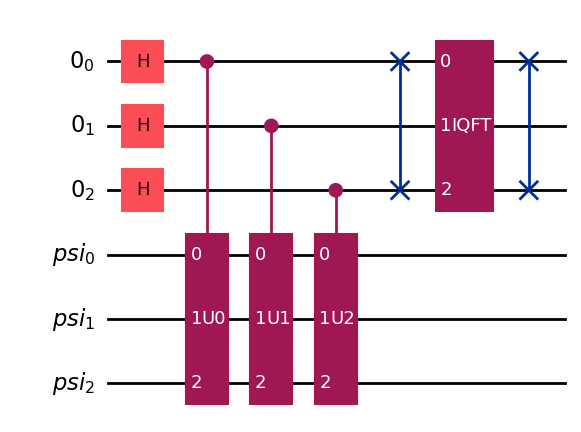

In [40]:
d = 3
n = 3
thetas = theta_input(d,n)
QPE(d,n,thetas).draw(output="mpl")

In [25]:
## We will need the inverse of QPE

def QPE_dagger(d,n,thetas):
    qr_0 = QuantumRegister(size=d, name="0")
    qr_psi = QuantumRegister(size=n, name="psi")

    qc = QuantumCircuit(qr_0, qr_psi,name=f'QPE_dagger')


    #Swap
    for q, p in zip(qr_0[:d >> 1], reversed(qr_0[d >> 1:])):
        qc.swap(q, p)

    # QFT
    qc.append(quantum_fourier_transform(d),qr_0[:])

       #Swap

    for q, p in zip(qr_0[:d >> 1], reversed(qr_0[d >> 1:])):
        qc.swap(q, p)
    

    
    #Hadamard gates on each |0>_d
    
    for i in range(d):
        U_i_inv = power_U_inverse(2**i,n,thetas).to_gate(label="U_inv"+str(i))
        U_i_inv_controlled = U_i_inv.control(1)

        qc.append(U_i_inv_controlled, [qr_0[i]] + qr_psi[:])
        
        qc.h(qr_0[i])
    

    return qc
        

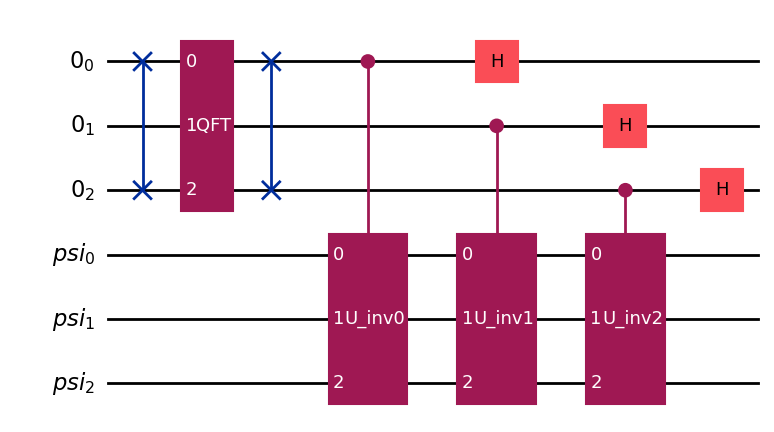

In [26]:
QPE_dagger(d,n,thetas).draw(output="mpl")

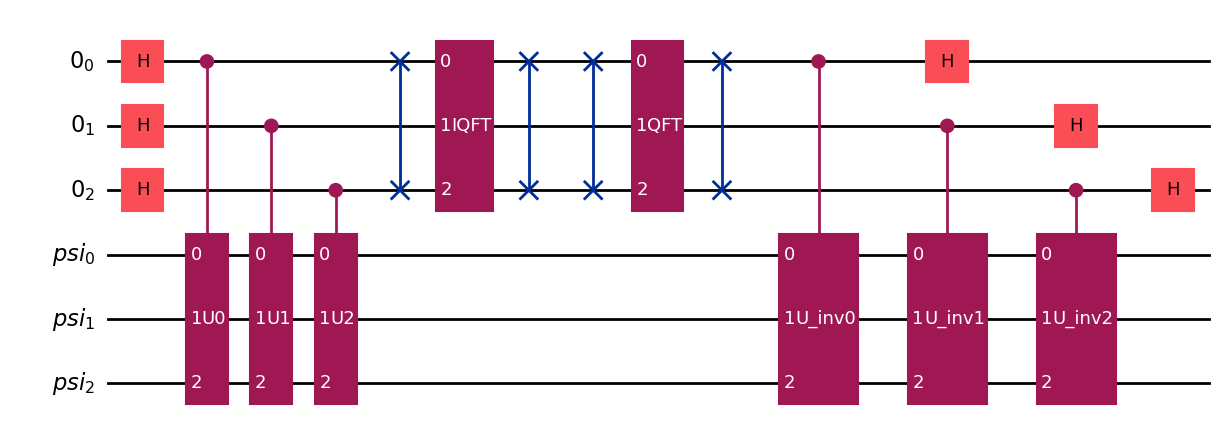

In [27]:
# Check if QPE composed with QPE_dagger gives identity
qr_0_check = QuantumRegister(size=d,name="0")
qr_psi_check = QuantumRegister(size=n, name="psi")
qc_check = QuantumCircuit(qr_0_check, qr_psi_check, name=f'id')
qc_check.compose(QPE(d,n,thetas),inplace=True)
qc_check.compose(QPE_dagger(d,n,thetas),inplace=True)
qc_check.draw(output="mpl")

In [28]:
np.round(Operator(qc_check).data) # Ok great this works.

array([[ 1.-0.j,  0.+0.j, -0.-0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.-0.j, -0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       [-0.-0.j, -0.+0.j,  1.-0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       ...,
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  1.-0.j,  0.-0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ..., -0.-0.j,  1.-0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  1.-0.j]],
      shape=(64, 64))

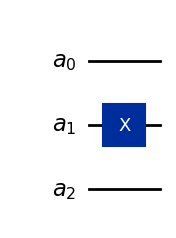

In [29]:
## The above circuit is useful on its own, so I am going to keep it.

# Now if I do not bake in the initial condition directly into the following circuit, it will become difficult later to chain the "Z_f"
# Grover's algorithm with the other operators. So I will bake in the initial condition with the |0>_d qubits, and construct Z_f.
# However, psi remains in our circuit.

#First let's make a function that puts the X gates in the right place to create the initial conditions for a number alpha in 2^d-1 |alpha>
blabla = QuantumRegister(size=3, name = "a")
def initial_conditions(alpha, qr): #Input : number alpha, quantum register qr
    qc = QuantumCircuit(qr)
    
    d = len(qr)
    bit_str = bit_string(alpha,d)[::-1] # I need to reverse because of qiskit indexing of register
    for i in range(d):
        if bit_str[i] == '1':
            qc.x(qr[i])
    return qc

initial_conditions(2,blabla).draw(output="mpl")

In [143]:
d = 3
n = 3

thetas = theta_input(d,n)
print(thetas)

[0.    0.625 0.875 0.75  0.375 0.125 0.5   0.25 ]


In [30]:
from qiskit.circuit.library import MCPhaseGate

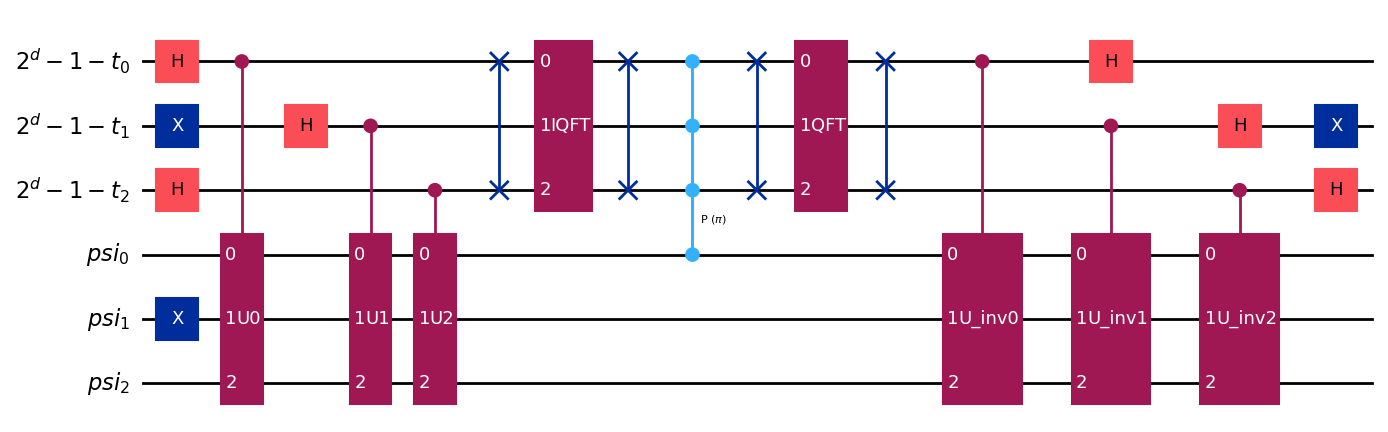

In [152]:
#This function measures what comes out of the QPE above. The "measurement" is performed by sampling over the probability distribution
# of the final state vector produced by the QPE circuit, and returning the "collapsed" state as a bit-string. 

# We do not construct MCP gate from scratch but use the qiskit implementation here. For how to construct this gate, refer to nb 1.

t = 5


def U_f(psi,d,n,thetas): # sv_ini is Initial State Vector to feed in to QPE

    #bit_str = bit_string_input(t,psi,d,n)

    qr_0= QuantumRegister(size=d,name="2^d-1-t")
    qr_psi = QuantumRegister(size=n,name="psi")

    qc = QuantumCircuit(qr_0,qr_psi)
    
    qc_0_ini = initial_conditions(2**d - 1 - t,qr_0)
    qc_psi_ini = initial_conditions(psi,qr_psi)

    qc.compose(qc_0_ini,qubits=qr_0[:],inplace=True)
    qc.compose(qc_psi_ini,qubits=qr_psi[:],inplace=True)
    
    
    
    
    qc_qpe = QPE(d,n,thetas)
    qc.compose(qc_qpe, qubits=qr_0[:] + qr_psi[:],inplace=True)

    #mcp_gate = MCPhaseGate(lam=np.pi, num_ctrl_qubits=3) # so that get a MCZ gate.

    #qc.append(mcp_gate, [0, 1, 2])

    qc.mcp(np.pi, qr_0,qr_psi[0])

    
    qc_qpe_dagger = QPE_dagger(d,n,thetas)
    qc.compose(qc_qpe_dagger, qubits = qr_0[:] + qr_psi[:], inplace=True)
    
    qc_0_ini_inv = initial_conditions(2**d - 1 - t,qr_0).inverse()
    qc.compose(qc_0_ini_inv,qubits=qr_0[:],inplace=True)
    
    #bit_str = bit_string_input(t,psi,d,n)

    #counter=0

    #=
        
    
    
    #sv_ini = bit_to_state(bit_str)

    return qc

psi = 2

qc = U_f(psi,d,n,thetas)
qc.draw(output="mpl")

    
    

In [166]:

sv_fin = Statevector(qc)
probs = sv_fin.probabilities()
#n_qubits = sv_fin.num_qubits
print("The expected value stored in |0>_d is",0)#2**d-1-t)
print("")
print("The value stored in |0>_d is",num_output(bit_string(np.random.choice(2**(d+n),p=probs),d+n)[::-1],d,n))

The expected value stored in |0>_d is 0

The output value of psi is 2
The value stored in |0>_d is 0


In [167]:
thetas # the value of the key psi depends both on t and the index of that value of t in thetas e.g here psi=2

array([0.   , 0.625, 0.875, 0.75 , 0.375, 0.125, 0.5  , 0.25 ])

In [168]:
probs

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 3.10556204e-33, 8.81513837e-32, 3.10556204e-33,
       2.41917228e-32, 4.09260113e-34, 1.01474970e-32, 4.09260113e-34,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [169]:
#I don't know how to check if we get a global phase on psi or not. One option is to check the MCZ separately. Assume it works for now.

In [170]:
# I want to check if the MCZ gate works to put the phase on psi
#from qiskit.quantum_info import Statevector, partial_trace
# Trace out qubit 1 (index 0 is qubit 0, index 1 is qubit 1)
#rho = partial_trace(sv_fin, [0,1,2])  # Keep qubit 0, trace out qubit 1
#print(rho)

In [171]:
# For modularity, I will now implement the H^n Z_OR H^n where Z_OR = X^n C^{n-1}Z X^n

def Z_or(n):

    qr_psi = QuantumRegister(size=n,name="psi")
    qc_z_or = QuantumCircuit(qr_psi,name=f'z_or')

    #qc_z_or.h(qr_psi)
    qc_z_or.x(qr_psi)

    qc_z_or.mcp(np.pi, qr_psi[0:n-1],qr_psi[-1]) # C^(n-1)Z

    qc_z_or.x(qr_psi)
    
    

    return qc_z_or

Z_or(3).draw(output="mpl")

print(np.round(Operator(Z_or(3)).data))
    

print("We have indeed implemented a Z_or which is pretty cool.")

[[-1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
We have indeed implemented a Z_or which is pretty cool.


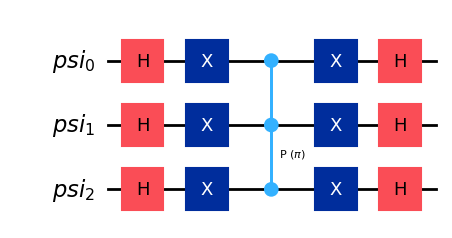

In [172]:
def S(n):
    qr_psi = QuantumRegister(size=n,name="psi")
    qc = QuantumCircuit(qr_psi, name=f'S') # Akos notation

    qc.h(qr_psi)
    qc.compose(Z_or(n),qubits=qr_psi,inplace=True)
    qc.h(qr_psi)

    return qc

S(3).draw(output="mpl")
    

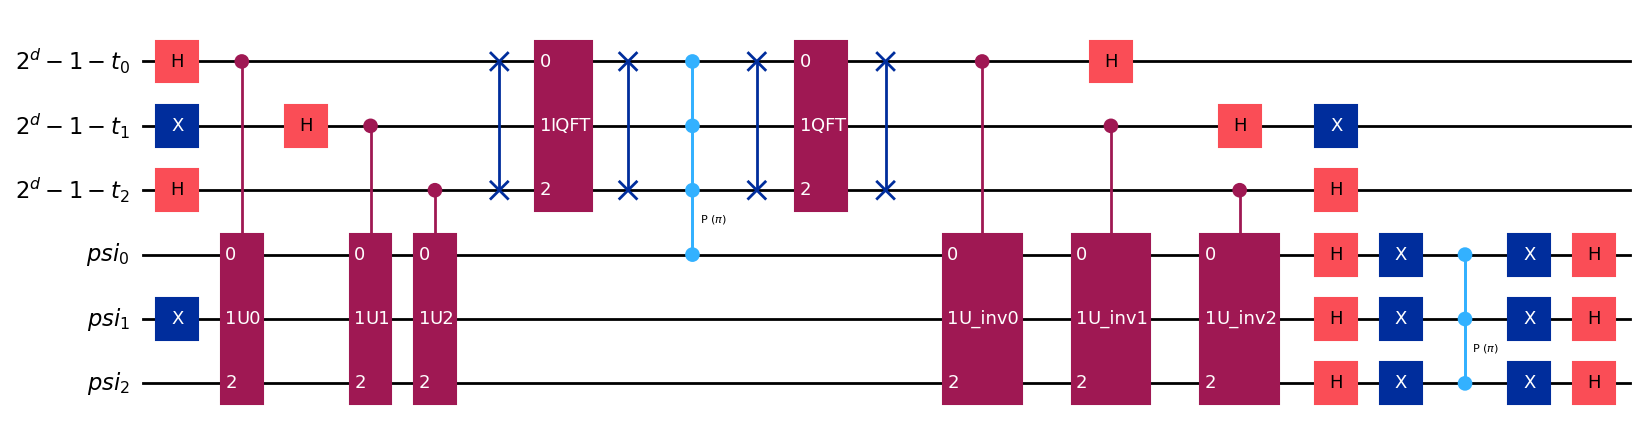

In [173]:
# Now we define G = - S . U_f
# I'm not sure how to do a minus sign. It's also not important, as we will converge to the correct state up to a sign.

def G(psi,d,n,thetas):
    qr_0= QuantumRegister(size=d,name="2^d-1-t")
    qr_psi = QuantumRegister(size=n,name="psi")

    qc = QuantumCircuit(qr_0,qr_psi)
    
    qc.compose(U_f(psi,d,n,thetas),qubits = qr_0[:] + qr_psi[:],inplace=True)
    qc.compose(S(n),qubits = qr_psi[:], inplace=True)

    return qc

#psi = 5
qc = G(psi,d,n,thetas)
qc.draw(output="mpl")
    
    

# Let's determine how many times we need to apply G. 
After $k$ iterations of Grover $G$, the probability of getting the key is given by
\begin{equation}
P = \sin^2 \left [ (2 k + 1) \sin^{-1} \left (\frac{1}{2^{n/2}} \right )  \right ]
\end{equation}
We maximize the probability by taking the argument to be $\simeq \pi/2$. This gives
\begin{equation}
k = \left \lfloor \frac{\pi}{4 \sin^{-1} \left ( \frac{1}{2^{n/2}} \right )} - \frac{1}{2} \right \rfloor
\end{equation}

In [188]:
np.pi/(4*np.arcsin(1/(2**(5/2)))) - 1/2

np.float64(3.919534679768386)

In [174]:
def k_iterations(n):
    return np.floor(np.pi/(4*np.arcsin(1/(2**(n/2)))) - 1/2).astype(int)

In [175]:
k_iterations(4)

np.int64(2)

In [176]:
def Grover_k(psi,d,n,thetas,k):
    qr_0= QuantumRegister(size=d,name="2^d-1-t")
    qr_psi = QuantumRegister(size=n,name="psi")

    qc = QuantumCircuit(qr_0,qr_psi)

    #create state |s> as an equal superposition of ALL basis states
    qc.h(qr_psi)

    

    for i in range(k):
        qc.barrier()

        qc.compose(G(psi,d,n,thetas),qubits = qr_0[:] + qr_psi[:],inplace=True)
        

    
    
    return qc

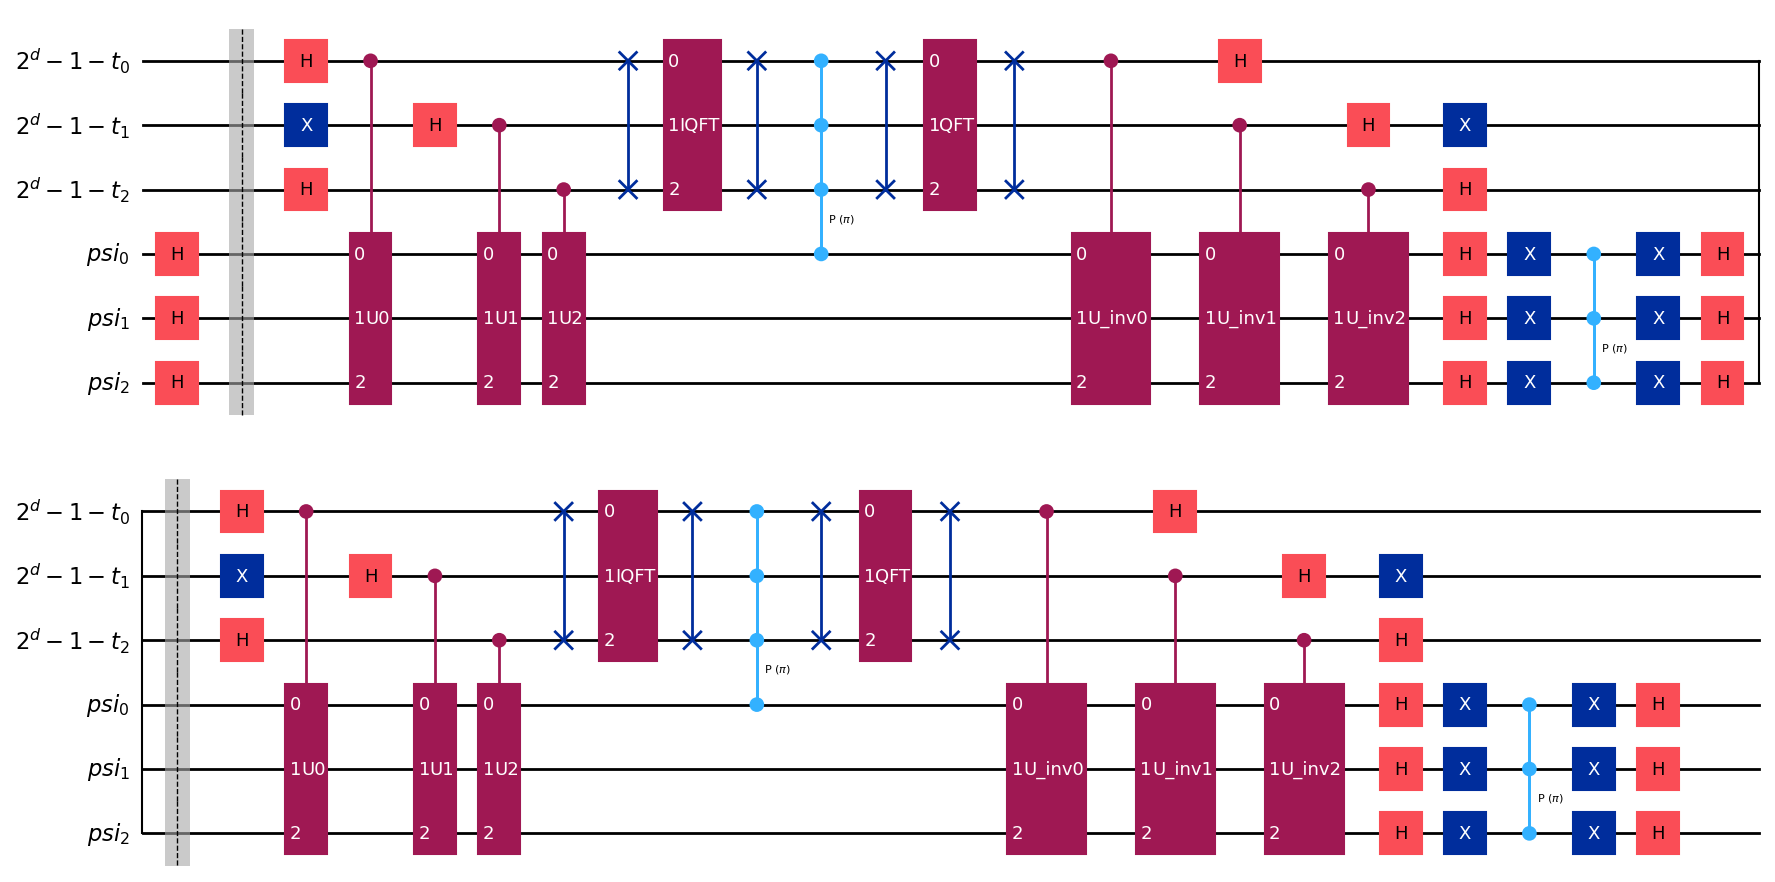

In [177]:
k=2
Grover_k(0,d,n,thetas,k).draw(output="mpl")

In [87]:
k_iterations(6)

np.int64(5)

In [189]:
d = 5
n = 5
thetas = theta_input(d,n)
print(thetas)

[0.59375 0.875   0.375   0.65625 0.6875  0.96875 0.625   0.40625 0.84375
 0.75    0.0625  0.1875  0.5     0.4375  0.25    0.71875 0.09375 0.15625
 0.3125  0.53125 0.03125 0.46875 0.78125 0.      0.8125  0.28125 0.125
 0.21875 0.34375 0.9375  0.5625  0.90625]


In [244]:


k= 3 #k_iterations(n)
qc = Grover_k(0,d,n,thetas,k)
#qc.draw(output="mpl")


In [245]:
sv_fin = Statevector(qc)
probs = sv_fin.probabilities()
#n_qubits = sv_fin.num_qubits
print("The expected value stored in |0>_d is",0)#2**d-1-t)
print("")
print("The value stored in |0>_d is",num_output(bit_string(np.random.choice(2**(d+n),p=probs),d+n)[::-1],d,n))

The expected value stored in |0>_d is 0

The output value of psi is 15
The value stored in |0>_d is 2


In [246]:
for i in range(len(probs)):
    if probs[i]>0.1:
        print(probs[i])
        print(i)

In [222]:
np.round(probs,2)[992]

np.float64(0.02)

## rough work below.

In [87]:
bit_string_input(1,3,3,3)

'100110'

In [331]:
#d=3
#n = 3
total_bits = d+n

num = 2

bit_str = bit_string_input(num,d,n)
print("bit_str",bit_str)
sv_ini = bit_to_state(bit_str)
print("Initial state vector is",sv_ini)
sv_fin = sv_ini.evolve(qc)
print("Final state vector is", sv_fin)
#state_to_bit(sv_fin,total_bits)

bit_str 000010
Initial state vector is Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2, 2, 2, 2))
Final state vector is Statevector([ 0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+

In [332]:
sv_fin.probabilities()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.35926418e-32, 2.10417156e-32, 1.00000000e+00, 2.10417156e-32,
       2.51333858e-32, 3.61018765e-33, 1.44973419e-33, 3.61018765e-33,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [336]:
 # Your evolved statevector
probs = sv_fin.probabilities()
n_qubits = sv_fin.num_qubits
num_output(bit_string(np.random.choice(2**n_qubits,p=probs),n_qubits)[::-1],d,n)

The output value of psi is 2


2

In [ ]:
sv.measure(qargs=[0,1,2])[1].data